In [4]:
from utility import *
from sampling import *
from pool import *


def runMe(sequence_length,num_rounds=3,scalar=10000):
    """
    Simulate a basic binding experiment.  
    """
    
    
    pipet = PipetteSampler()
    screen = BindingSampler()
    amplify = PhageAmplificationSampler()

    pool = Pool(sequence_length=sequence_length,alphabet=AMINO_ACIDS)
    pool.createUniformPool(100*scalar,1e6)

    print(0,pool.current_counts.size,sum(pool.current_counts))
    for i in range(num_rounds):
        pool.addNewStep(*pipet.runExperiment(pool,1000*scalar))
        pool.addNewStep(*screen.runExperiment(pool,1*scalar))
        pool.addNewStep(*amplify.runExperiment(pool,1000*scalar),checkpoint=True)

        print(i+1,pool.current_counts.size,sum(pool.current_counts))
    
    return pool


In [5]:
pool = runMe(2,num_rounds=3,scalar=1000)


0 400 100000
1 123 1000000
2 61 1000000
3 43 1000000


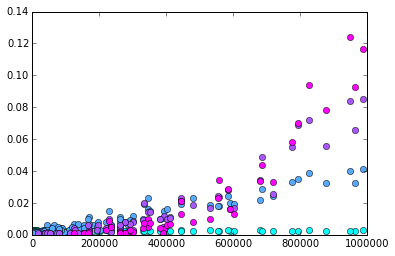

In [6]:

import matplotlib.pyplot as plt
%matplotlib inline

pool.round_affinities(0)

m = max(pool.checkpoints)
for i in pool.checkpoints:
    plt.plot(pool.round_affinities(i),pool.round_counts(i)/np.sum(pool.round_counts(i)),"o",color=[i/m,1-i/m,1])
plt.show()
    